# Librerias

In [1]:
try:
    import torch
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False

import numpy as np

from pathlib import Path

from __future__ import annotations

import matplotlib.pyplot as plt

import pandas as pd

import pyproj



# Configs

In [2]:
CLIP_TENSOR_SPEC = {
    "image_frames": torch.uint8,
    "camera_indices": torch.int64,
    "ego_history_xyz": torch.float32,
    "ego_history_rot": torch.float32,
    "ego_future_xyz": torch.float32,
    "ego_future_rot": torch.float32,
    "relative_timestamps": torch.float32,
    "absolute_timestamps": torch.int64,
}

# Funciones

In [3]:
def clip_to_tensors(
    clip: dict,
    device: str | None = None,
) -> dict:
    """
    Converts a clip (dict with numpy arrays or loaded from .npz) to a dict of PyTorch tensors.
    Keeps the same keys and shapes; t0_us and clip_id are copied as scalars.
    """
    if not HAS_TORCH:
        raise ImportError("pip install torch")
    out = {}
    for key, arr in clip.items():
        # Copy these keys as scalar values (do not convert to tensor)
        if key in ("t0_us", "clip_id"):
            out[key] = arr
            continue
        # Ignore unknown keys
        if key not in CLIP_TENSOR_SPEC:
            continue
        # Ensure the array is a numpy array
        if not isinstance(arr, np.ndarray):
            arr = np.asarray(arr)
        dtype = CLIP_TENSOR_SPEC[key]
        t = torch.from_numpy(arr).to(dtype)
        # Move tensor to the target device if given
        if device is not None:
            t = t.to(device)
        out[key] = t
    return out


def load_clip_as_tensors(
    npz_path: str | Path,
    device: str | None = None,
    meta_path: str | Path | None = None,
) -> dict:
    """
    Loads a clip from a .npz file, optionally reads its _meta.txt, and returns a dict of tensors.
    """
    if not HAS_TORCH:
        raise ImportError("PyTorch is not installed. pip install torch")
    npz_path = Path(npz_path)
    data = np.load(npz_path, allow_pickle=False)
    clip = {k: data[k] for k in data.files}
    # Try to locate or use the provided meta_path
    if meta_path is None:
        meta_path = npz_path.parent / (npz_path.stem + "_meta.txt")
    meta_path = Path(meta_path)
    if meta_path.exists():
        with open(meta_path) as f:
            for line in f:
                line = line.strip()
                # Read t0_us or clip_id if present in meta file
                if line.startswith("t0_us="):
                    clip["t0_us"] = int(line.split("=", 1)[1])
                elif line.startswith("clip_id="):
                    clip["clip_id"] = line.split("=", 1)[1]
    return clip_to_tensors(clip, device=device)


def show_one(img_chw):
    # Show a CHW image tensor using matplotlib
    img = img_chw.permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def rotate_90cc(xy):
    # Rotate a 2D point or vector 90 degrees counter-clockwise
    return np.stack([-xy[1], xy[0]], axis=0)


# Clips Analysis

In [6]:
PATH = "../dataset/output-examples/sample"
data = np.load(f"{PATH}.npz")
tensors = clip_to_tensors(data, device="cpu")


In [7]:
tensors.keys()

dict_keys(['image_frames', 'camera_indices', 'ego_history_xyz', 'ego_history_rot', 'ego_future_xyz', 'ego_future_rot', 'relative_timestamps', 'absolute_timestamps'])

In [8]:
tensors['ego_history_xyz']

tensor([[[[-4.8342,  0.1263, -0.8474],
          [-4.5211,  0.1300, -0.7409],
          [-4.2147,  0.1328, -0.6085],
          [-3.9083,  0.1356, -0.4762],
          [-3.6018,  0.1385, -0.3438],
          [-3.2954,  0.1413, -0.2115],
          [-2.9890,  0.1441, -0.0791],
          [-2.6535,  0.1508, -0.0583],
          [-2.3155,  0.1581, -0.0552],
          [-1.9777,  0.1339, -0.0512],
          [-1.6411,  0.1255, -0.0468],
          [-1.3036,  0.1059, -0.0484],
          [-0.9759,  0.1128, -0.0351],
          [-0.6482,  0.0628, -0.0282],
          [-0.3263,  0.0695, -0.0101],
          [ 0.0000,  0.0000,  0.0000]]]])

# Save tensor

In [9]:
PATH_TENSOR = "../dataset/output-examples/clip_sample.pt"
torch.save(tensors, PATH_TENSOR)  


# Visualization

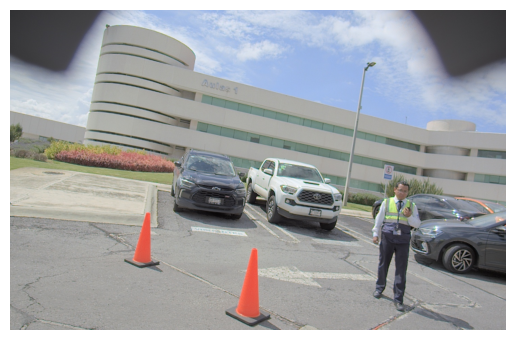

In [60]:
tensors["camera_indices"] = torch.as_tensor(
    tensors["camera_indices"],
    device=tensors["image_frames"].device
)

# Momentum timeframes [0, 1, 2, 3]
momentum = 0

cam_ids = tensors["camera_indices"]        
idx = torch.where(cam_ids == momentum)[0].item()

imgs_r = tensors["image_frames"][:, idx]  

show_one(imgs_r[3])

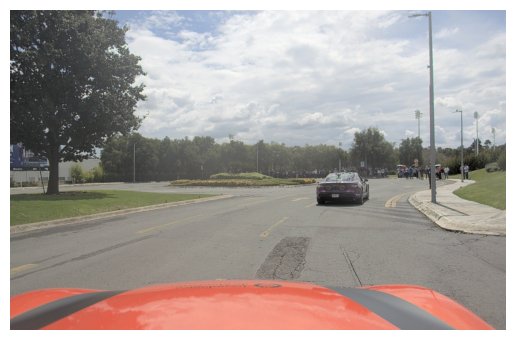

In [61]:

tensors["camera_indices"] = torch.as_tensor(
    tensors["camera_indices"],
    device=tensors["image_frames"].device
)

# Momentum timeframes [0, 1, 2, 3]
momentum = 0

cam_ids = tensors["camera_indices"]        
idx = torch.where(cam_ids == momentum)[0].item()

imgs_r = tensors["image_frames"][:, idx]  

# index camara
show_one(imgs_r[0])





# Ground Truth



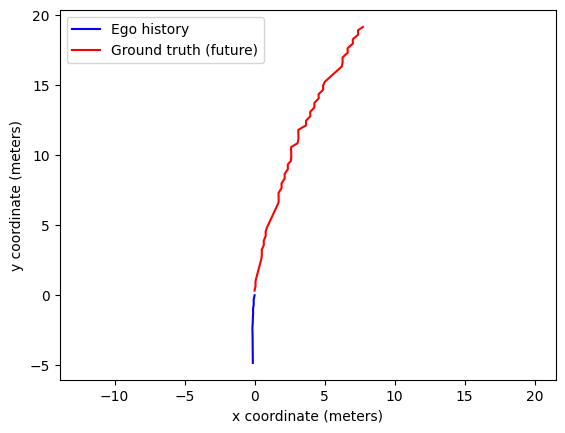

In [10]:
hist_xy = tensors["ego_history_xyz"].squeeze()[:, :2].T.numpy()  # (2, 16)
fut_xy = tensors["ego_future_xyz"].squeeze()[:, :2].T.numpy()    # (2, 64)

hist_xy_rot = rotate_90cc(hist_xy)
fut_xy_rot = rotate_90cc(fut_xy)

plt.plot(*hist_xy_rot, "b-", label="Ego history")
plt.plot(*fut_xy_rot, "r-", label="Ground truth (future)")
plt.ylabel("y coordinate (meters)")
plt.xlabel("x coordinate (meters)")
plt.legend(loc="best")
plt.axis("equal")
plt.show()

# Dataset debugg

## Orientation

In [ ]:
#IMPORTANTE: Ten a la mano los archivos finales de orientation y pose

df = pd.read_csv("orientation.csv")
pd.set_option('display.float_format', '{:.6f}'.format)

df['quat_norm_sq'] = df['orientation.x']**2 + df['orientation.y']**2 + df['orientation.z']**2 + df['orientation.w']**2

df

,t,orientation.x,orientation.y,orientation.z,orientation.w,quat_norm_sq
0,1760116966.052967,-0.018327,0.008409,0.238043,-0.971045,1.000000
1,1760116966.062860,-0.018287,0.008408,0.237984,-0.971061,1.000000
2,1760116966.077845,-0.018259,0.008408,0.237931,-0.971074,1.000000
3,1760116966.087939,-0.018229,0.008407,0.237882,-0.971087,1.000000
4,1760116966.102899,-0.018214,0.008409,0.237830,-0.971100,1.000000
...,...,...,...,...,...,...
19916,1760117236.140095,0.019806,0.009639,-0.060295,0.997938,1.000000
19917,1760117236.150105,0.019814,0.009638,-0.060378,0.997932,1.000000
19918,1760117236.165096,0.019815,0.009641,-0.060449,0.997928,1.000000
19919,1760117236.180074,0.019818,0.009634,-0.060519,0.997924,1.000000


## Pose

In [64]:
pose = pd.read_csv("pose.csv")

pose['delta_sec'] = pose['sec'].diff().fillna(0)
pose['delta_elapsed'] = pose['elapsed'].diff().fillna(0)
pose['delta_latitude'] = pose['latitude'].diff().fillna(0)
pose['delta_longitude'] = pose['longitude'].diff().fillna(0)
pose['delta_altitude'] = pose['altitude'].diff().fillna(0)

proj = pyproj.Transformer.from_crs(4326, 32616, always_xy=True)
pose['lon_x'], pose['lat_y'] = proj.transform(pose['longitude'].values, pose['latitude'].values)


pose['delta_x'] = np.sqrt(pose['lon_x'].diff().fillna(0)**2 + pose['lat_y'].diff().fillna(0)**2)
pose['delta_y'] = pose['lon_x'].diff().fillna(0)**2 + pose['lat_y'].diff().fillna(0)**2
pose['delta_z'] = pose['altitude'].diff().fillna(0)
pose['x'] = pose['delta_x'].cumsum()
pose['y'] = pose['delta_y'].cumsum()
pose['z'] = pose['delta_z'].cumsum()

pose_df = pose[['t','sec','elapsed', 'x', 'y', 'z']]

pose_df

,t,sec,elapsed,x,y,z
0,1.760117e+09,1760116966,0.000000,0.000000,0.000000,0.000000
1,1.760117e+09,1760116966,0.009893,0.012072,0.000146,-0.001820
2,1.760117e+09,1760116966,0.024878,0.075526,0.004172,-0.000808
3,1.760117e+09,1760116966,0.034972,0.087817,0.004323,-0.002620
4,1.760117e+09,1760116966,0.049932,0.104119,0.004589,-0.003623
...,...,...,...,...,...,...
15241,1.760117e+09,1760117236,270.087127,969.206523,764.306214,-5.385699
15242,1.760117e+09,1760117236,270.097138,969.245606,764.307742,-5.379935
15243,1.760117e+09,1760117236,270.112129,969.310597,764.311966,-5.379059
15244,1.760117e+09,1760117236,270.127107,969.375427,764.316169,-5.378149
